This notebook looks examine what size flare is required in order to meet our science goals.
1. The attenuated spectra are used to compute the effective area required to meet the goals
2. An effective area is assumed and the expected photon rates are computed

Note that this notebook uses data not included in the Git repo, so you will need to run `mcmurdo_station_attenuation.py` for various flare magnitudes in order to use the full functionality of this notebook.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from adetsim.atmoatt.atmospheric_attenuator import generate_flare_spectrum, plot_spectrum

/home/reed/.pyenv/versions/3.12.6/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  4.17file/s]


In [2]:
def filter_histogram_bins(
    values: np.ndarray,
    bins: np.ndarray,
    bin_range: tuple
) -> tuple[np.ndarray, np.ndarray]:
    """
    Filters histogram bins to contain only bins within the specified range.
    Returns values, bins.
    """

    inds = np.asarray( (bins >= bin_range[0]) & (bins <= bin_range[1]) ).nonzero()[0]
    values = values[inds[0]:inds[-1]]
    bins = bins[inds]

    return values, bins

# Effective area for flares

Requires that simulated spectra be computed for **C1, C5, M1, M5, X1, X5, and X9 flares**.
The effective area required to meet Trevor's timing definition is computed for pre-defined energy bins for each flare magnitude.
This does **NOT** account for detection efficiency; this is purely examining *photon* rates, **NOT** *count* rates.

Flare class: X9
11.0 keV - 26.0 keV : 134.4803676055148 ph / (s cm2)
effective area needed to meet science requirements energy range [11. 26.] keV: 18.560329990484377 cm2
26.0 keV - 50.0 keV : 932.1389517383022 ph / (s cm2)
effective area needed to meet science requirements energy range [26. 50.] keV: 2.677712368252959 cm2
50.0 keV - 200.0 keV : 2386.9622629030914 ph / (s cm2)
effective area needed to meet science requirements energy range [ 50. 200.] keV: 1.045680545013851 cm2
11.0 keV - 200.0 keV : 3460.1590067677625 ph / (s cm2)
effective area needed to meet science requirements energy range [ 11. 200.] keV: 0.7213541328933285 cm2


Flare class: X5
11.0 keV - 26.0 keV : 60.02065590373388 ph / (s cm2)
effective area needed to meet science requirements energy range [11. 26.] keV: 41.585683502081224 cm2
26.0 keV - 50.0 keV : 447.3744524039577 ph / (s cm2)
effective area needed to meet science requirements energy range [26. 50.] keV: 5.5792188994874286 cm2
50.0 keV - 200.0 keV : 966.954

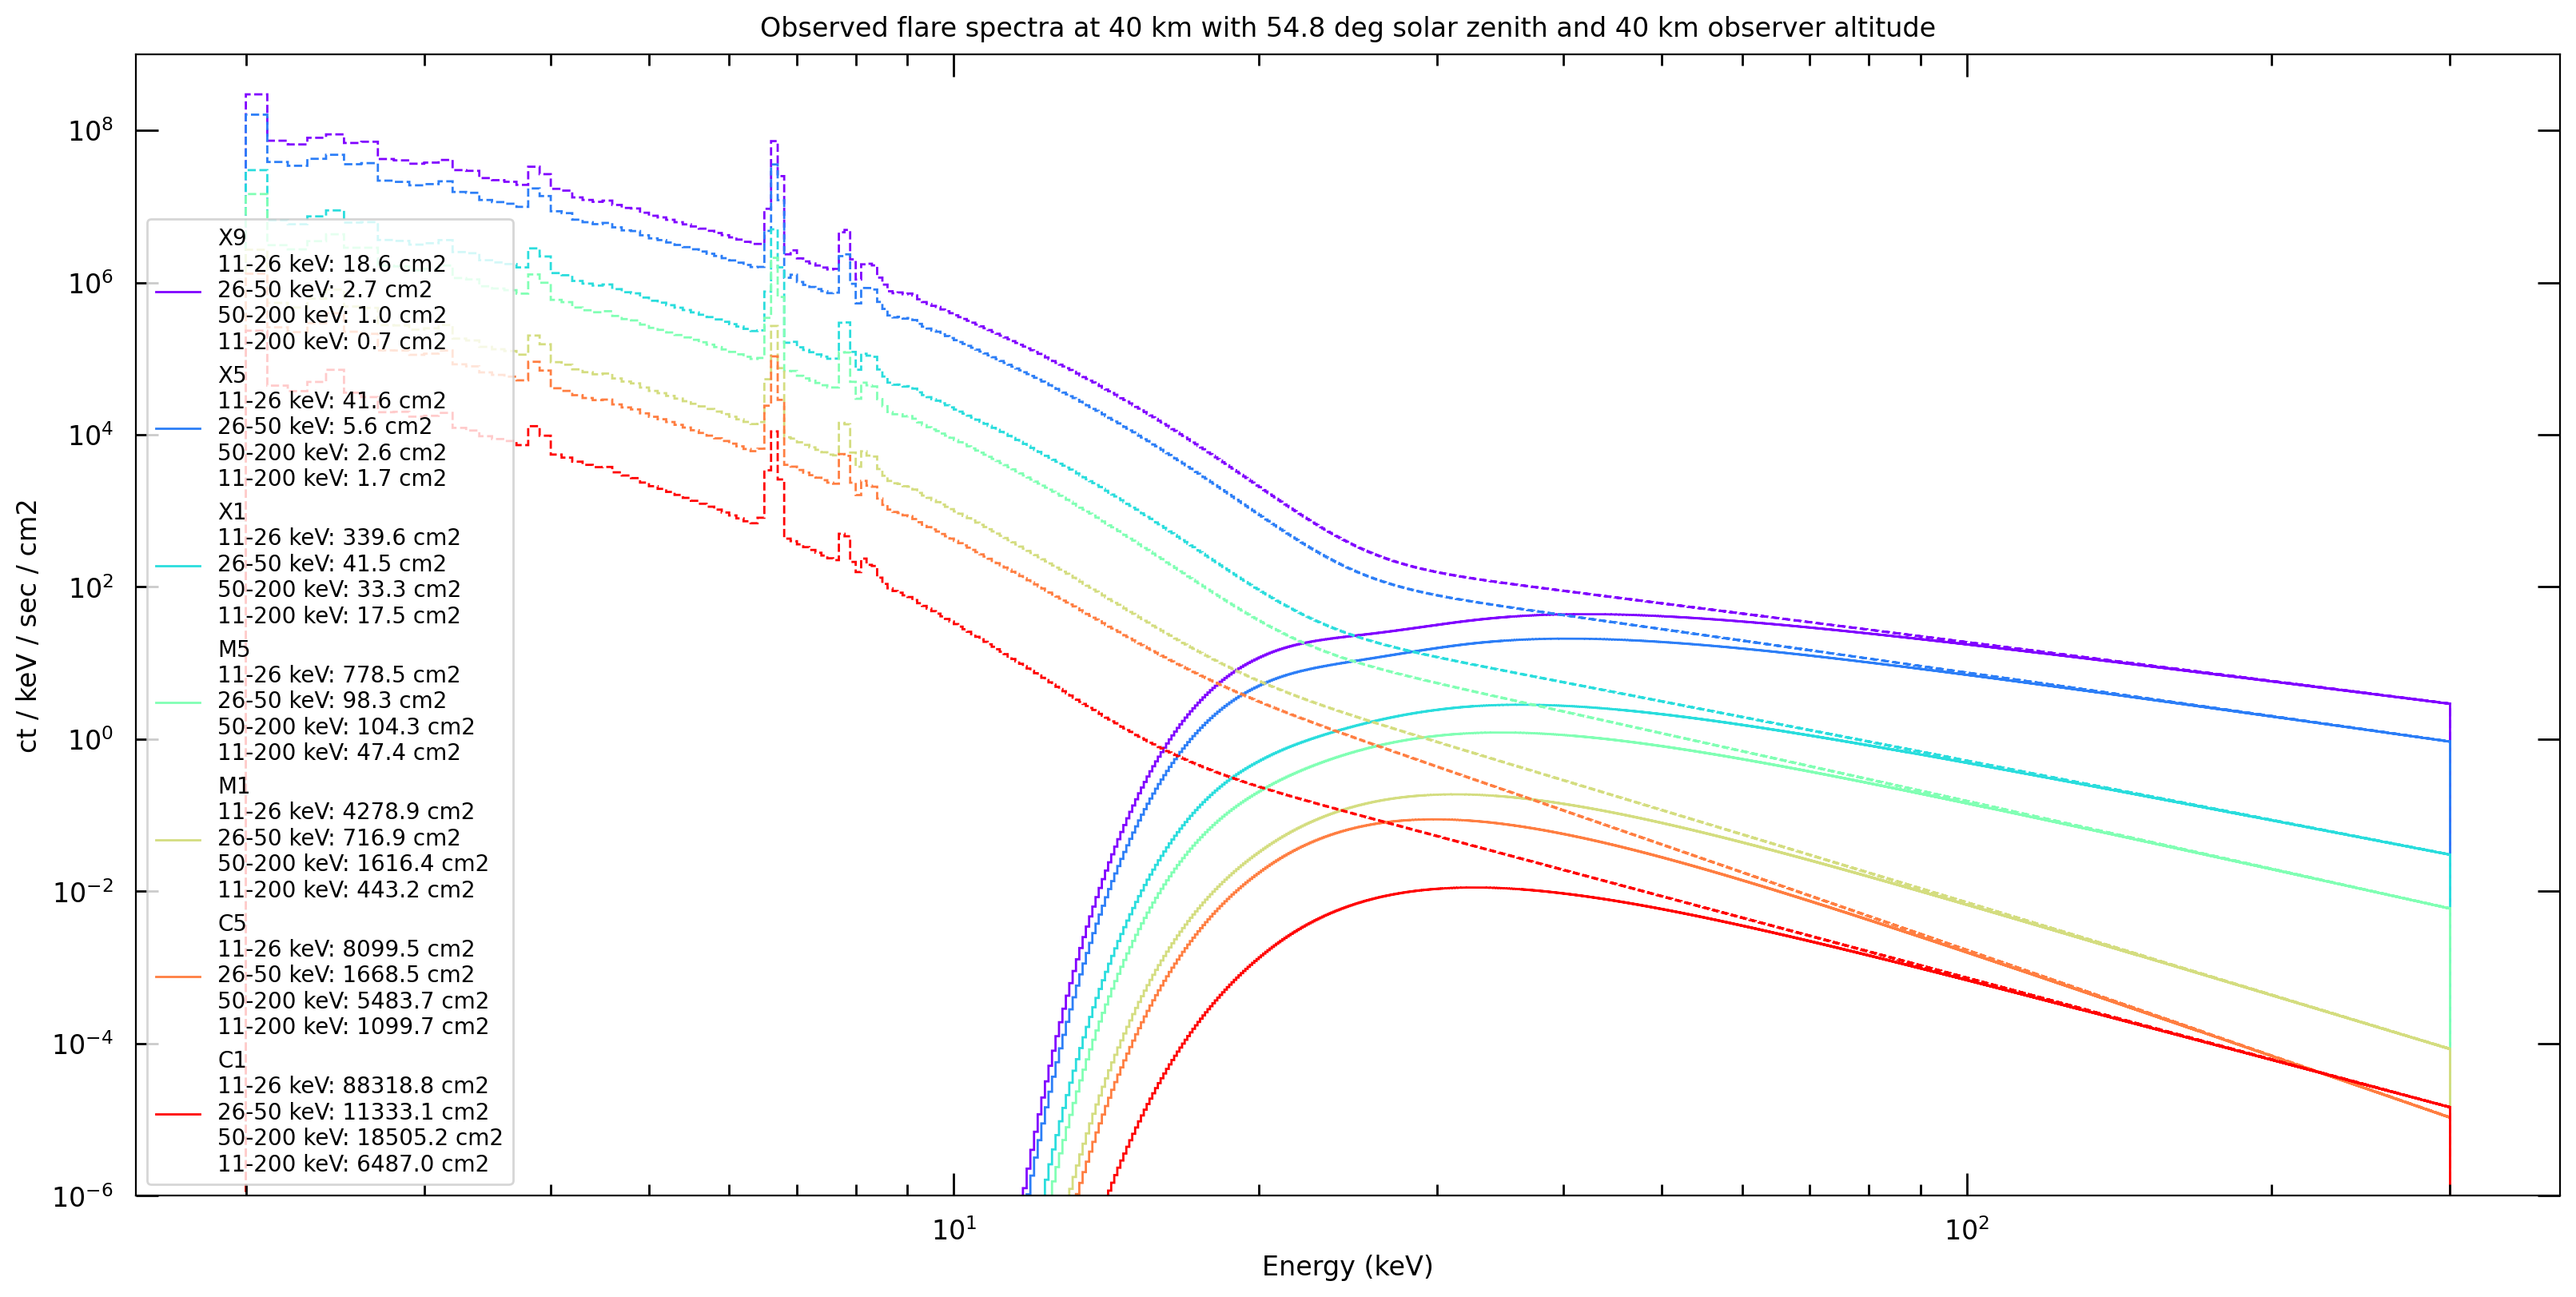

In [3]:
%matplotlib inline

in_dir = './mcmurdo-station-attenuation'
flares = ['C1', 'C5', 'M1', 'M5', 'X1', 'X5', 'X9']
fig, ax = plt.subplots(figsize=(16,8), layout='constrained')
colors = plt.cm.rainbow(np.linspace(0, 1, len(flares)))

for i, flare in enumerate(reversed(flares)):
    print('Flare class:', flare)
    file = os.path.join(in_dir, f'{flare}-layer-attenuation-zenith54.8deg/40.0km.pkl')
    with open(file, 'rb') as infile:
        attenuated = pickle.load(infile)
    
    label = f'{flare}'
    # ranges = [ (10, 40) * u.keV, (40, 80) * u.keV, (80, 300) * u.keV, (10, 300) * u.keV]
    ranges = [ (11, 26) * u.keV, (26, 50) * u.keV, (50, 200) * u.keV, (11, 200) * u.keV]
    for energy_range in ranges:
        edges = attenuated.energy_edges
        spectrum = attenuated.flare
        filt_spectrum, filt_edges = filter_histogram_bins(spectrum, edges, energy_range.value)

        cpspa = np.sum(filt_spectrum*np.diff(filt_edges)) * u.ph / u.s / (u.cm)**2
        print(f'{energy_range[0]} - {energy_range[1]} : {cpspa}')

        eff_area = 156 * u.ph / (cpspa * (1/16) * u.s)
        print(f'effective area needed to meet science requirements energy range {energy_range}:', eff_area)

        label += f'\n{energy_range[0].value:.0f}-{energy_range[1].value:.0f} {energy_range[0].unit}: {eff_area.value:.1f} {eff_area.unit}'
    print('\n')

    original = generate_flare_spectrum(flare)
    ax = plot_spectrum(attenuated, ax=ax, color=colors[i], label=label)
    plot_spectrum(original, ax=ax, color=colors[i], ls='--')

ax.set_title('Observed flare spectra at 40 km with 54.8 deg solar zenith and 40 km observer altitude')
ax.legend()
plt.savefig(os.path.join(in_dir, 'effective_area_requirements.png'))
plt.show()

# Transmission probability through atmosphere

This plot shows the fraction of flare photons that transmit from the top of the atmosphere down to 40 km.
The absorption through the atmosphere is agnostic to flare class (given our model assumptions).

[Text(0.5, 0, 'Energy [keV]'),
 Text(0, 0.5, 'Fraction at 40 km'),
 (0.01, 1.0439248338909823),
 None]

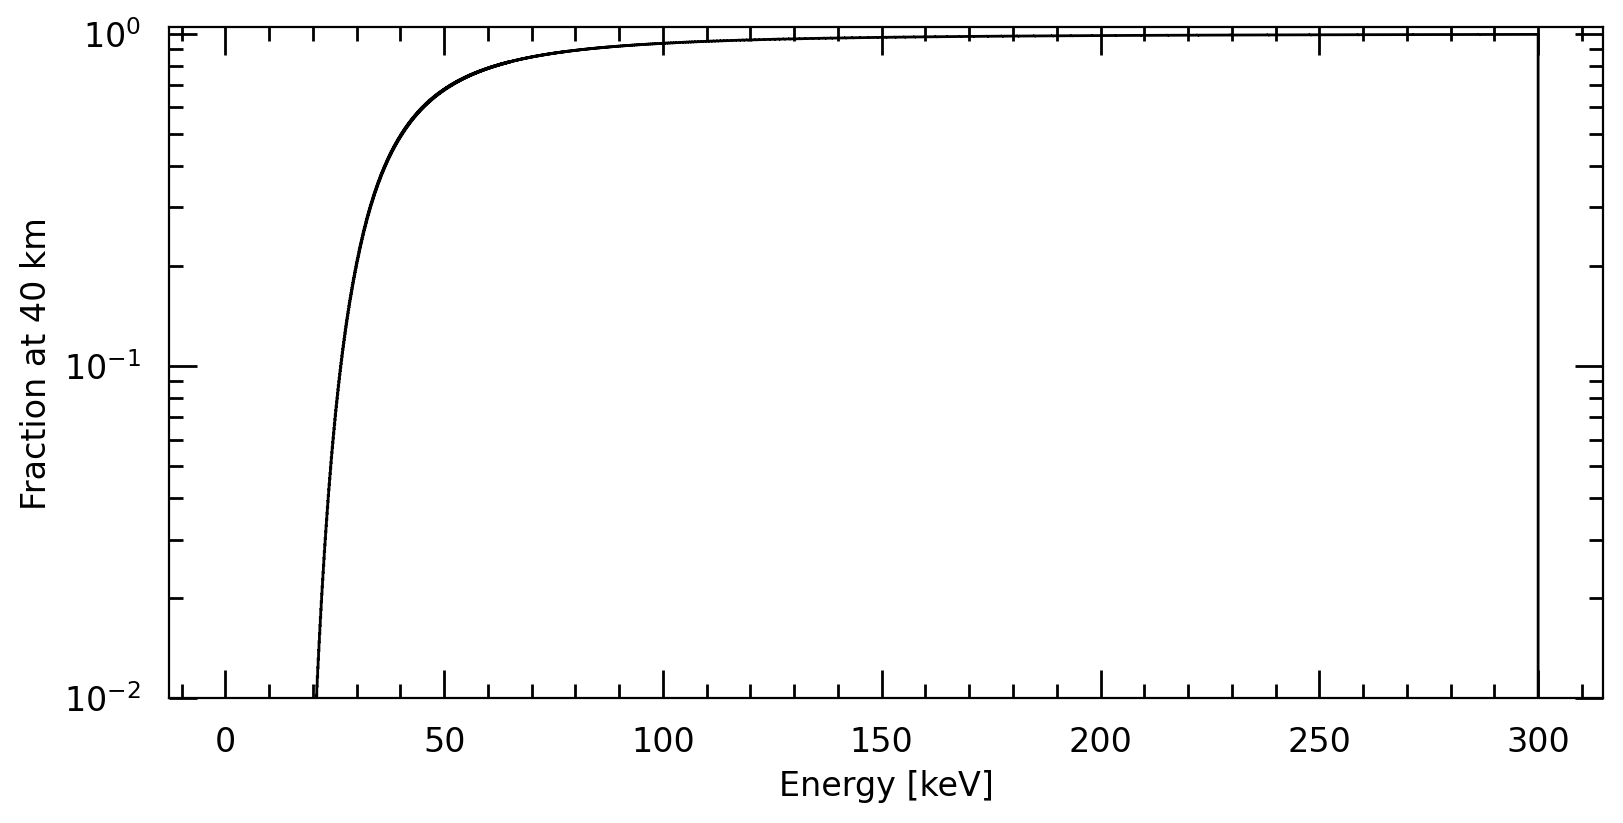

In [32]:
in_dir = './mcmurdo-station-attenuation'
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
colors = plt.cm.rainbow(np.linspace(0, 1, len(flares)))

flare = 'X1'
file = os.path.join(in_dir, f'{flare}-layer-attenuation-zenith54.8deg/40.0km.pkl')
with open(file, 'rb') as infile:
    attenuated = pickle.load(infile)

edges = attenuated.energy_edges
spectrum = attenuated.flare
original = generate_flare_spectrum(flare)

ax.stairs(spectrum/original.flare, edges, color='black')
ax.set(
    xlabel='Energy [keV]',
    ylabel='Fraction at 40 km',
    ylim=(1e-2, ax.get_ylim()[1]),
    yscale='log'
)

# Photon rates

Compute the photons rates expected from an assumed effective area.

## Total photon rates per flare

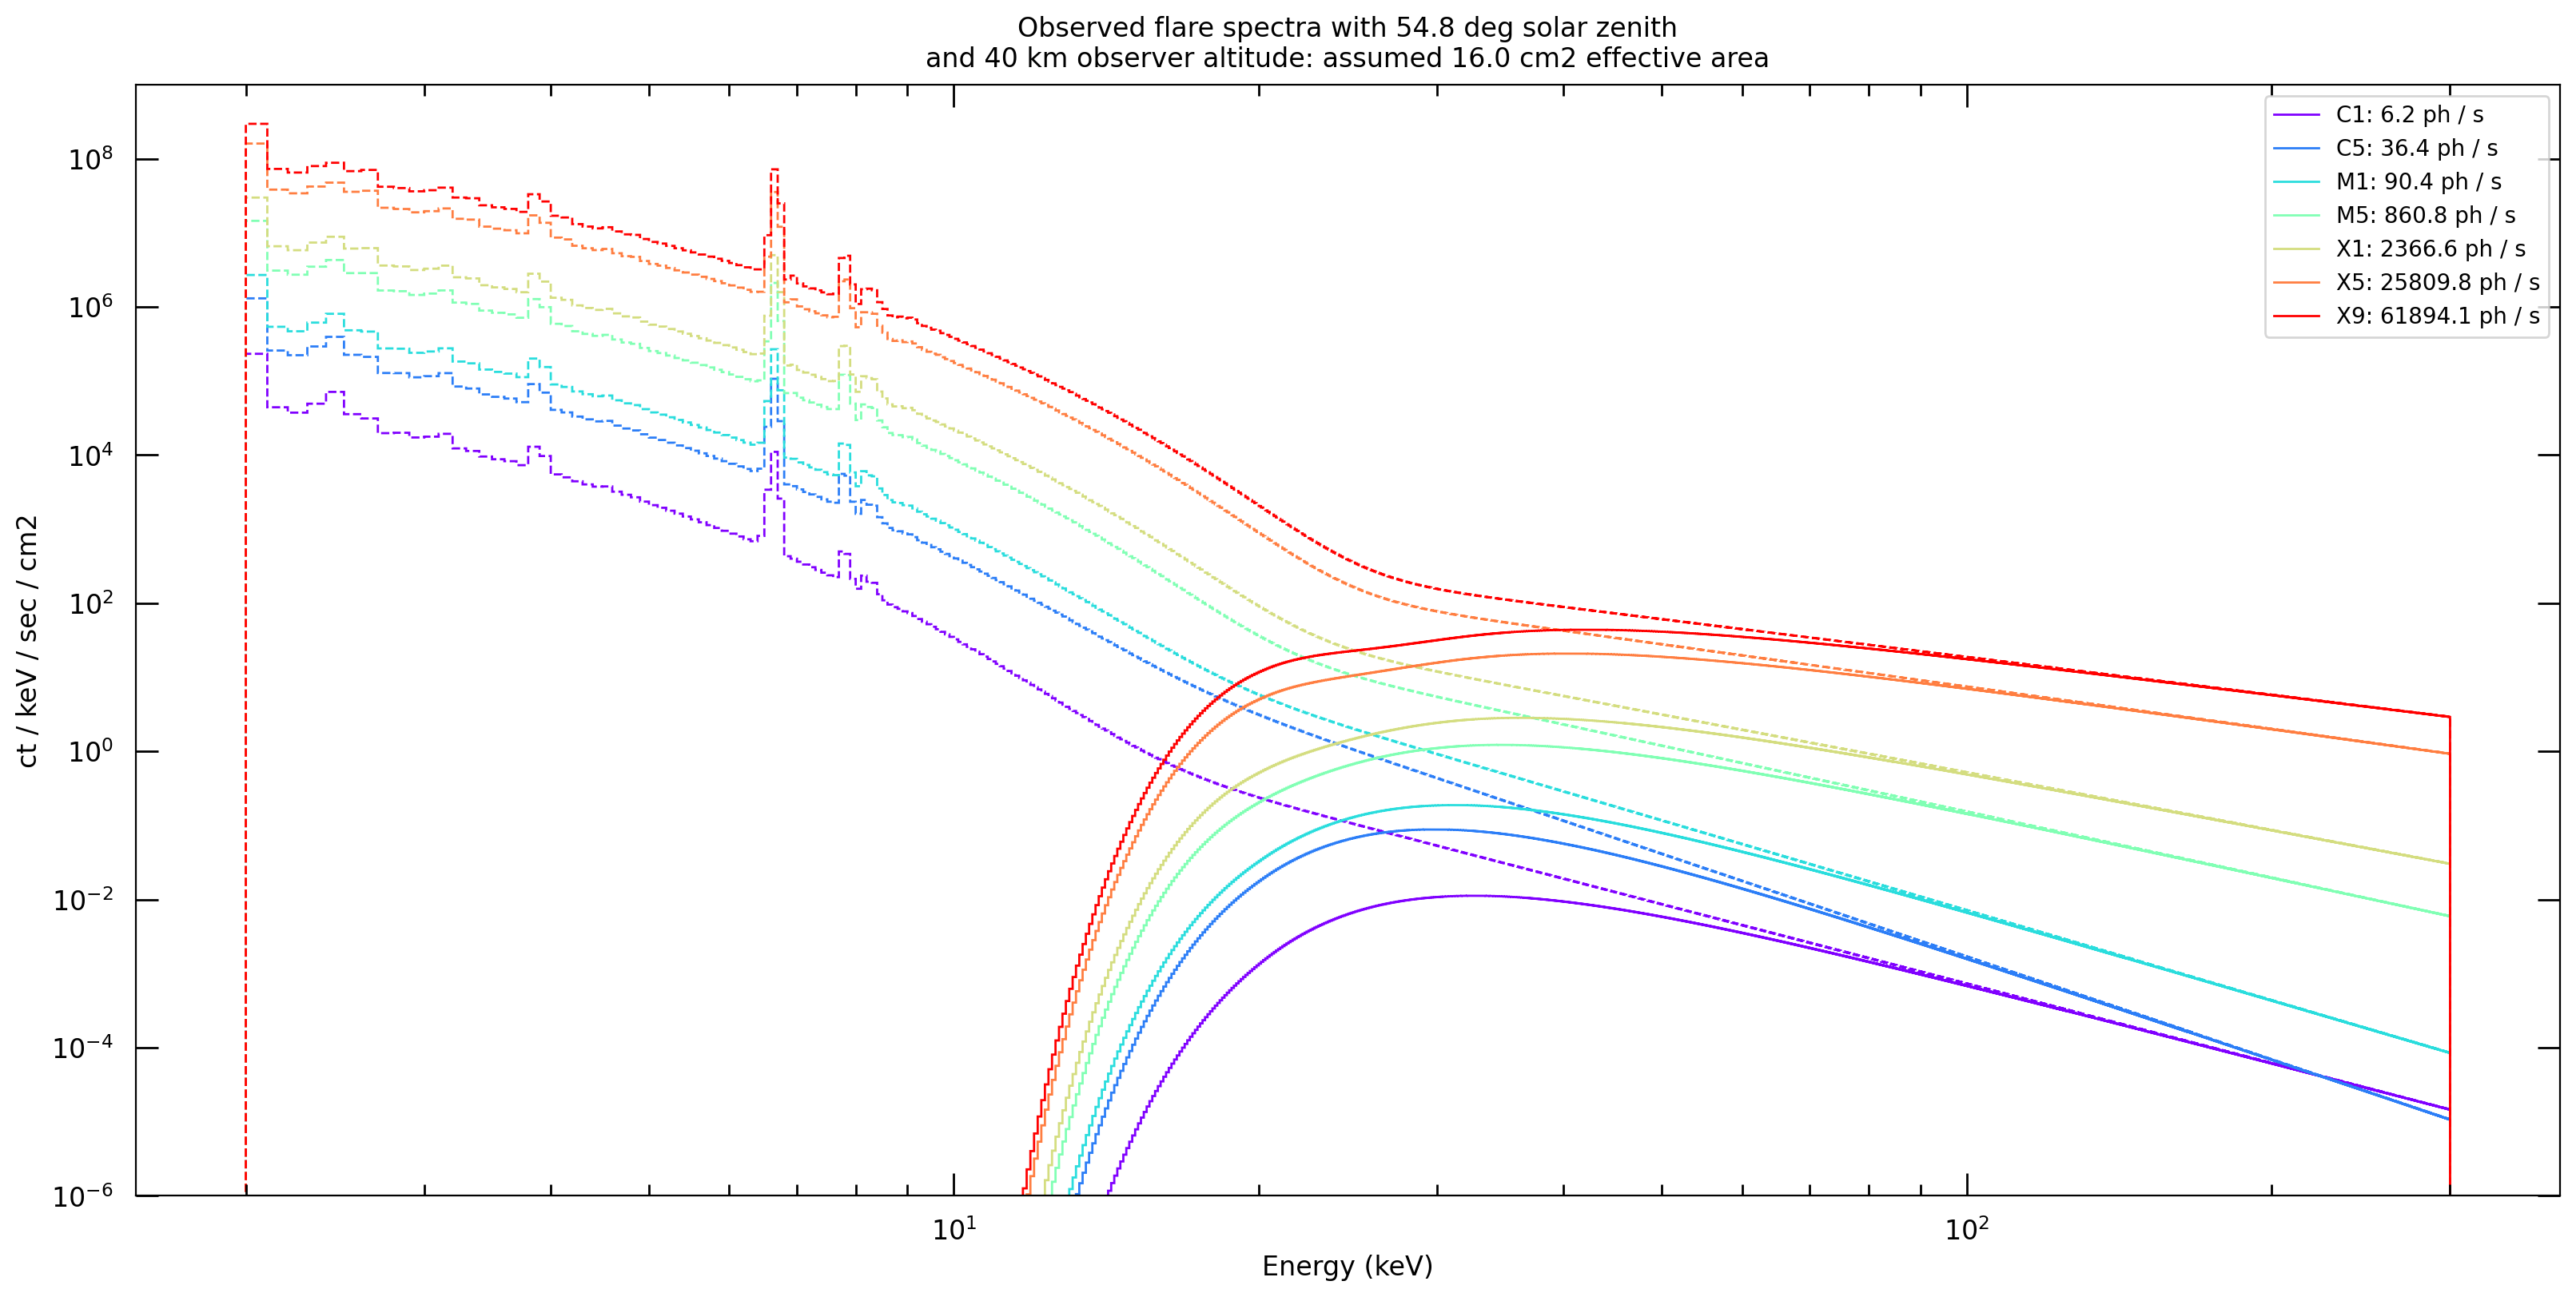

In [16]:
%matplotlib inline

effective_area = 16 * (u.cm)**2
flares = ['C1', 'C5', 'M1', 'M5', 'X1', 'X5', 'X9']
fig, ax = plt.subplots(figsize=(16,8), layout='constrained')
colors = plt.cm.rainbow(np.linspace(0, 1, len(flares)))

for i, flare in enumerate(flares):
    file = os.path.join(in_dir, f'{flare}-layer-attenuation-zenith54.8deg/40.0km.pkl')
    with open(file, 'rb') as infile:
        attenuated = pickle.load(infile)
    
    edges = attenuated.energy_edges * u.keV
    spectrum = attenuated.flare * u.ph/u.s/(u.cm**2)/u.keV
    plate_xray_cps = spectrum * np.diff(edges) * effective_area
    label = f'{flare}: {np.sum(plate_xray_cps):0.1f}'

    original = generate_flare_spectrum(flare)
    ax = plot_spectrum(attenuated, ax=ax, color=colors[i], label=label)
    plot_spectrum(original, ax=ax, color=colors[i], ls='--')

ax.set_title(f'Observed flare spectra with 54.8 deg solar zenith\nand 40 km observer altitude: assumed {(effective_area<<u.cm**2).value} cm2 effective area')
ax.legend()
plt.savefig(os.path.join(in_dir, 'count_rates.png'))
plt.show()

## Photon rates per energy band

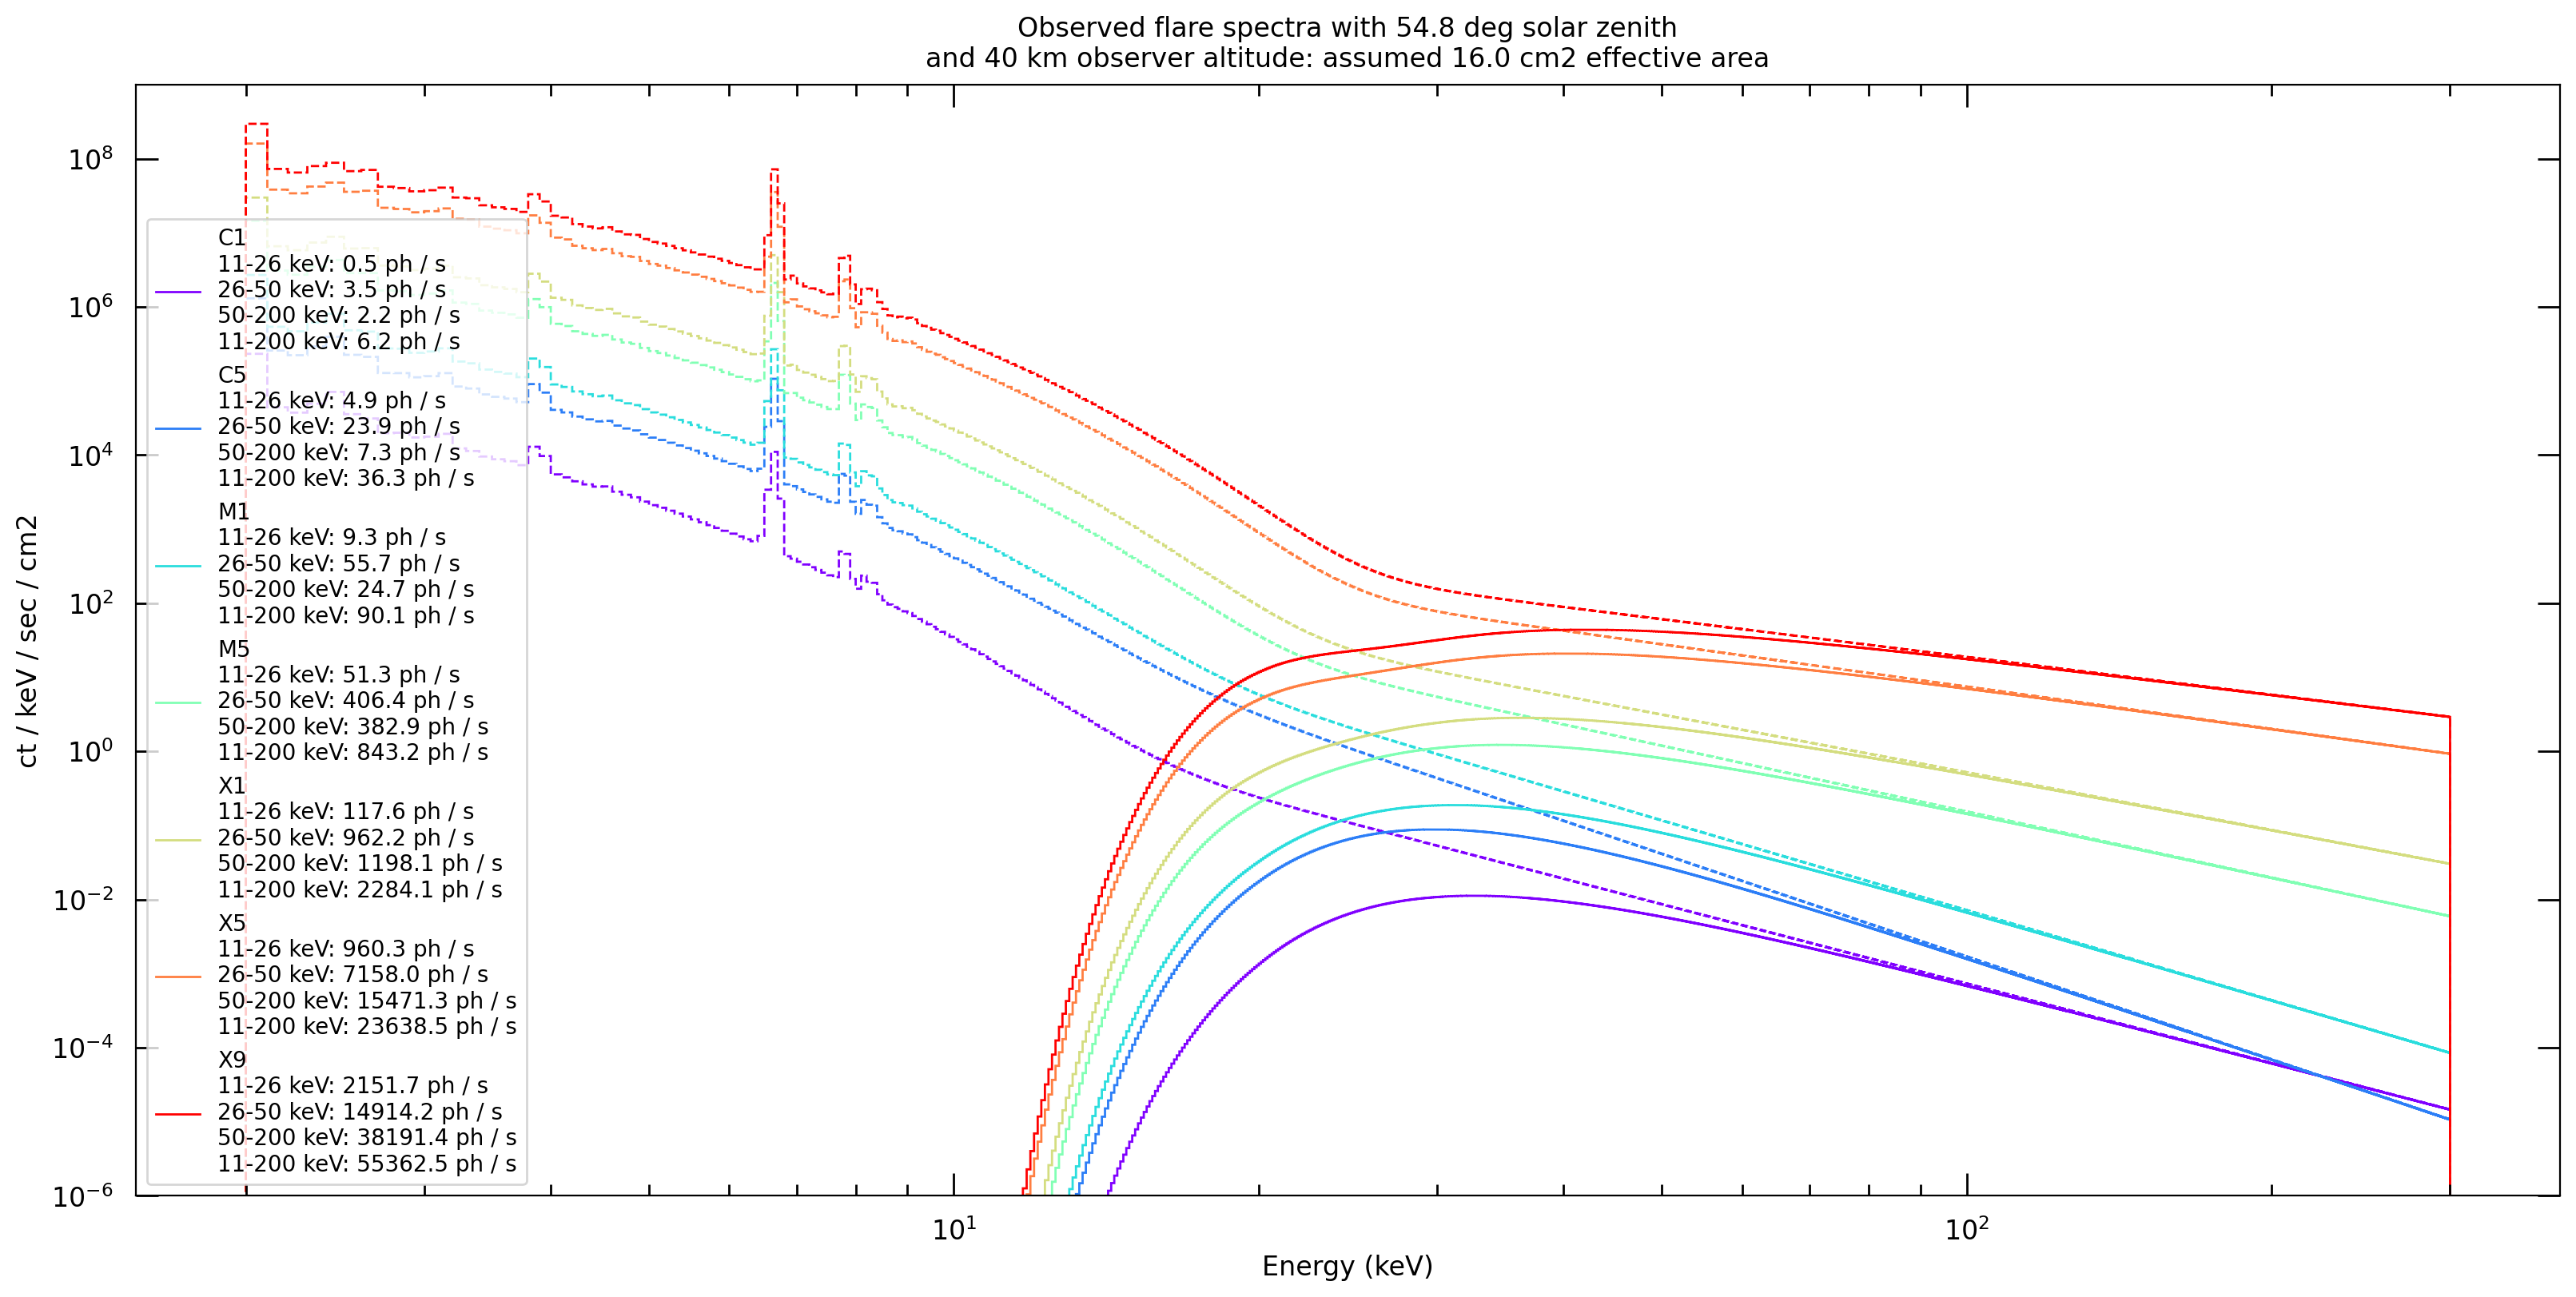

In [18]:
flares = ['C1', 'C5', 'M1', 'M5', 'X1', 'X5', 'X9']
fig, ax = plt.subplots(figsize=(16,8), layout='constrained')
colors = plt.cm.rainbow(np.linspace(0, 1, len(flares)))

for i, flare in enumerate(flares):
    file = os.path.join(in_dir, f'{flare}-layer-attenuation-zenith54.8deg/40.0km.pkl')
    with open(file, 'rb') as infile:
        attenuated = pickle.load(infile)
    
    label = f'{flare}'
    # ranges = [ (10, 40) * u.keV, (40, 80) * u.keV, (80, 300) * u.keV, (10, 300) * u.keV]
    ranges = [ (11, 26) * u.keV, (26, 50) * u.keV, (50, 200) * u.keV, (11, 200) * u.keV]
    for energy_range in ranges:
        edges = attenuated.energy_edges
        spectrum = attenuated.flare
        filt_spectrum, filt_edges = filter_histogram_bins(spectrum, edges, energy_range.value)

        filt_edges = filt_edges * u.keV
        filt_spectrum = filt_spectrum * u.ph/u.s/(u.cm**2)/u.keV
        plate_xray_cps = np.sum(filt_spectrum * np.diff(filt_edges) * effective_area)

        label += f'\n{energy_range[0].value:.0f}-{energy_range[1].value:.0f} {energy_range[0].unit}: {plate_xray_cps.value:.1f} {plate_xray_cps.unit}'

    original = generate_flare_spectrum(flare)
    ax = plot_spectrum(attenuated, ax=ax, color=colors[i], label=label)
    plot_spectrum(original, ax=ax, color=colors[i], ls='--')

ax.set_title(f'Observed flare spectra with 54.8 deg solar zenith\nand 40 km observer altitude: assumed {(effective_area<<u.cm**2).value} cm2 effective area')
ax.legend()
plt.savefig(os.path.join(in_dir, 'count_rates_energy_bands.png'))
plt.show()

# Plotting attenuated flare

This is an example examining the M1-class flare.

## M1 flare

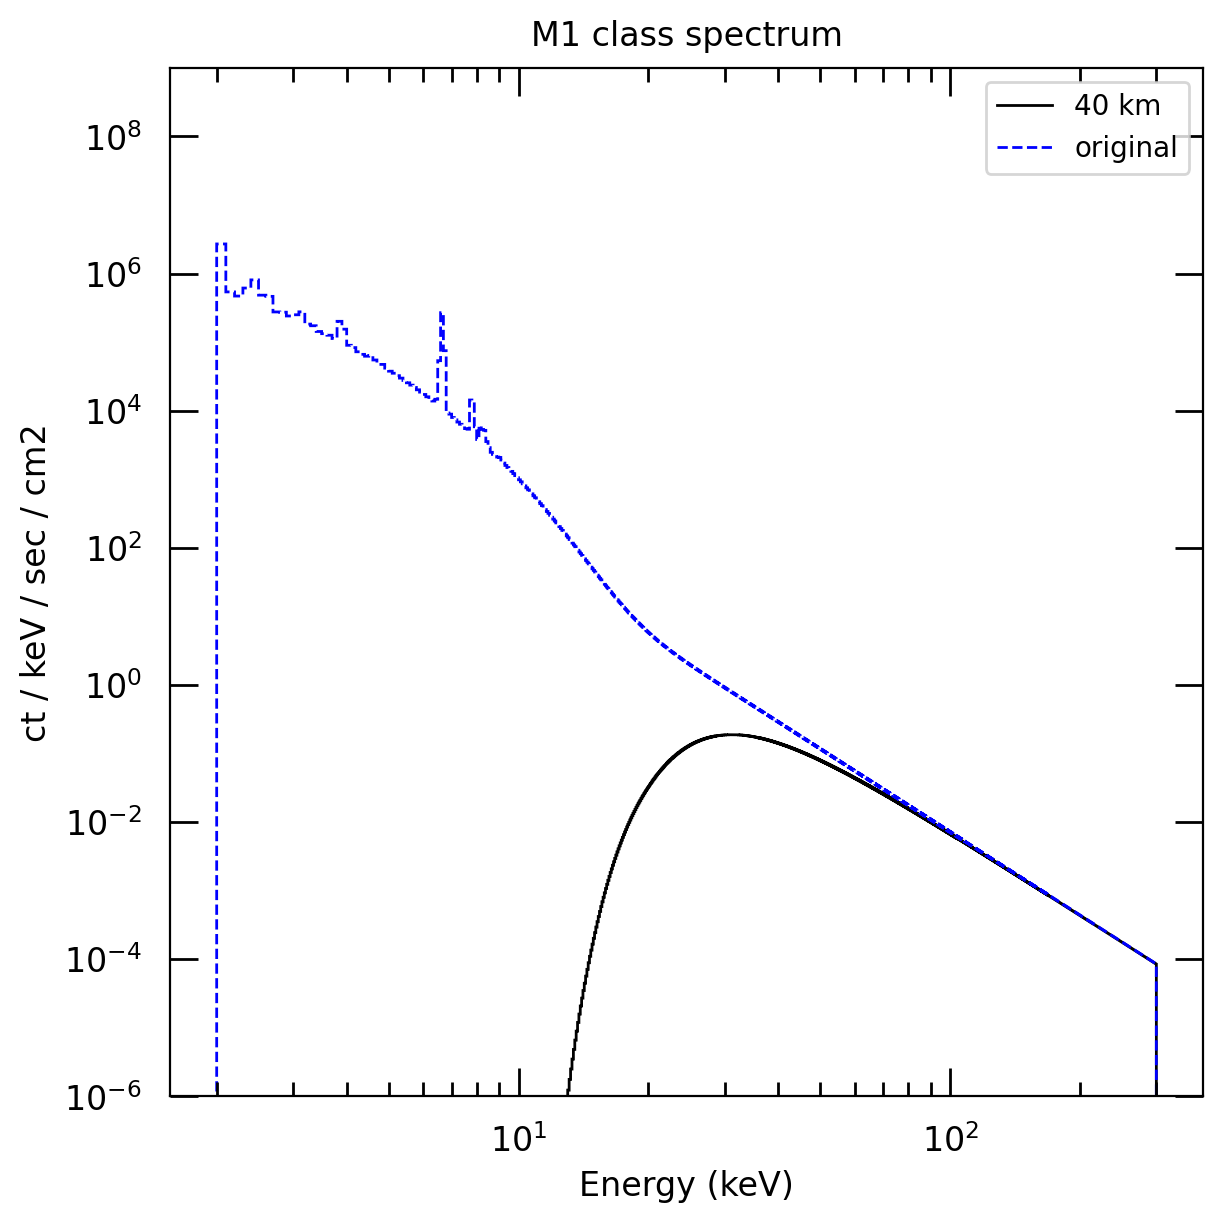

In [24]:
flare_class = 'M1'
flare_file = os.path.join(in_dir, f'{flare_class}-layer-attenuation-zenith54.8deg/40.0km.pkl')
with open(flare_file, 'rb') as infile:
    attenuated_flare = pickle.load(infile)

original_flare = generate_flare_spectrum(flare_class)
ax = plot_spectrum(attenuated_flare, color='black', label='40 km')
plot_spectrum(original_flare, ax=ax, color='blue', ls='--', label='original')
ax.legend()

## Minimum effective area

Checking Knuth thesis calculation

In [34]:
energy_range = (10, 26.1) * u.keV
edges = attenuated_flare.energy_edges
spectrum = attenuated_flare.flare
spectrum, edges = filter_histogram_bins(spectrum, edges, energy_range.value)

cpspa = np.sum(spectrum*np.diff(edges)) * u.ph / u.s / (u.cm)**2
print('photon rate:', cpspa)

eff_area = 156 * u.ph / (cpspa * (1/16) * u.s)
print(f'effective area needed to meet science requirements for {energy_range[0]} - {energy_range[1]} for {flare_class} class flare:', eff_area)

photon rate: 0.5982646330739554 ph / (s cm2)
effective area needed to meet science requirements for 10.0 keV - 26.1 keV for M1 class flare: 4172.0667778325 cm2
